In [14]:
!pip install imblearn


Epoch [1] - Train Loss: 0.6822, Valid Loss: 1.0094, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5124
Model saved at epoch 1 with F1 Score: 0.4534
Epoch [2] - Train Loss: 0.6213, Valid Loss: 1.0103, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [3] - Train Loss: 0.6099, Valid Loss: 1.0111, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [4] - Train Loss: 0.6054, Valid Loss: 1.0112, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [5] - Train Loss: 0.6093, Valid Loss: 1.0109, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [6] - Train Loss: 0.6097, Valid Loss: 1.0109, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [7] - Train Loss: 0.6092, Valid Loss: 1.0109, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [8] - Train Loss: 0.6090, Valid Loss: 1.0109, Precision: 0.2931, Recall: 1.0000, F1 Score: 0.4534, AUC: 0.5000
Epoch [9] - Train L

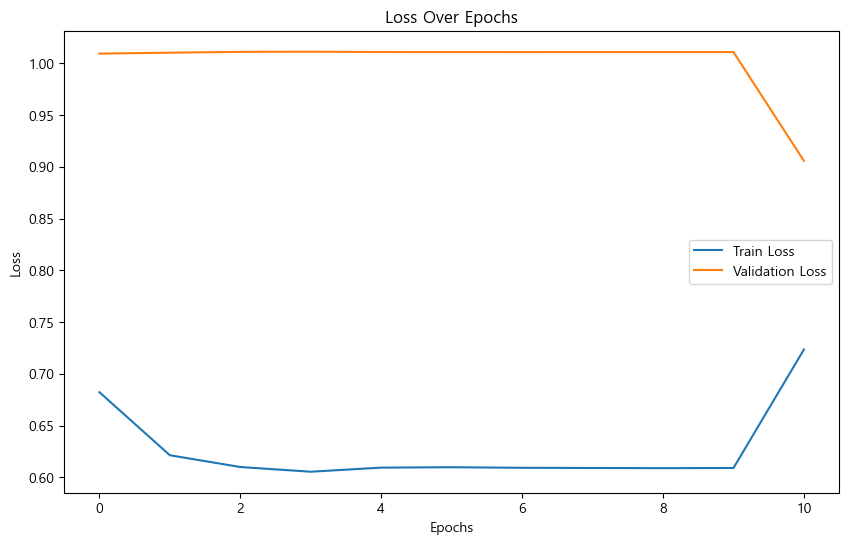

Text(0.5, 1.0, 'Validation F1 Score Over')

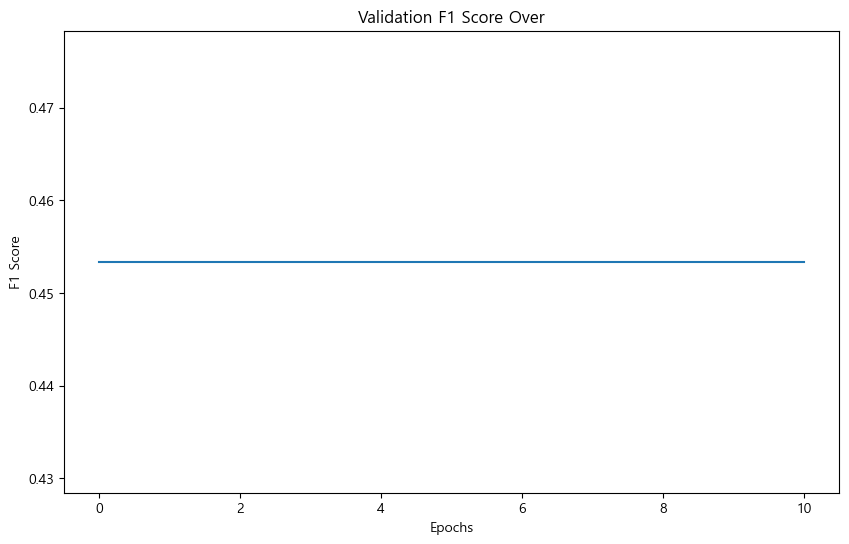

In [2]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# 모델 저장 경로 생성
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "best_model.pt")

# 데이터 로드
data = pd.read_csv('./dataset/train_result.csv')

# 특성과 타겟 분리
X = data.drop(columns=['Churn'])  # 'Churn' 타겟 변수
y = data['Churn']

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 오버샘플링
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 텐서로 변환
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# PyTorch 모델 정의
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.layer2 = nn.Linear(2048, 1024)
        self.layer3 = nn.Linear(1024, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 128)
        self.layer6 = nn.Linear(128, 64)
        self.layer7 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # 출력층에서 sigmoid 활성화 함수 사용

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        x = torch.relu(self.layer7(x))
        x = self.sigmoid(self.output(x))  # 출력층 적용
        return x

# 모델 초기화
input_size = X_train_tensor.shape[1]
model = SimpleNN(input_size)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()  #
l2_reg = 0.01  # L2 정규화 강도
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_reg)  # 옵티마이저에 L2 정규화 적용
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 학습률 감소 스케줄러

# 조기 종료 및 모델 저장 변수
best_score = 0  
patience = 10
trigger_cnt = 0

# 학습/검증 결과 저장
train_losses = []
valid_losses = []
valid_acc_list = []
valid_precision_list = []
valid_recall_list = []
valid_f1_list = []
valid_auc_list = []

# 학습 루프
s = time.time()
epoch = 0
while True:  # 무한 루프
    epoch += 1

    # Training
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), 32):  # 배치 크기 32
        X_batch = X_train_tensor[i:i + 32]
        y_batch = y_train_tensor[i:i + 32]
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train_tensor) // 32
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        outputs = model(X_test_tensor)
        valid_loss = criterion(outputs, y_test_tensor).item()
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(y_test_tensor.cpu().numpy())

    # Additional Metrics
    threshold=0.7
    f1 = f1_score(all_labels, (np.array(all_preds) > threshold).astype(int))
    precision = precision_score(all_labels, (np.array(all_preds) > threshold).astype(int))
    recall = recall_score(all_labels, (np.array(all_preds) > threshold).astype(int))
    auc = roc_auc_score(all_labels, all_preds)
    valid_losses.append(valid_loss)
    valid_f1_list.append(f1)
    valid_precision_list.append(precision)
    valid_recall_list.append(recall)
    valid_auc_list.append(auc)

    print(f"Epoch [{epoch}] - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

    # Save the best model based on F1 Score
    if f1 > best_score:  # F1 Score 기준으로 성능 개선 판단
        torch.save(model.state_dict(), save_path)
        best_score = f1
        trigger_cnt = 0
        print(f"Model saved at epoch {epoch} with F1 Score: {f1:.4f}")
    else:
        trigger_cnt += 1
        if trigger_cnt >= patience:
            print(f"Early stopping at epoch {epoch} with best F1 Score: {best_score:.4f}")
            break

    # 학습률 업데이트
    scheduler.step()

e = time.time()
print("Training completed in {:.2f}s".format(e - s))

# 손실 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# 검증 F1 Score 그래프
plt.figure(figsize=(10, 6))
plt.plot(valid_f1_list, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score Over")


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from itertools import product

# 모델 저장 디렉토리 생성
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "best_model.pkl")

# 데이터 로드
data = pd.read_csv('./dataset/train_result.csv')

# 특성과 타겟 분리
X = data.drop(columns=['Churn'])  
y = data['Churn']

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 오버샘플링으로 데이터 불균형 해결
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 텐서로 변환
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# PyTorch 모델 정의
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = self.output(x)
        return x

# 하이퍼파라미터 그리드 정의
learning_rates = [0.001, 0.0001]
epochs_list = [20, 100, 500]
thresholds = [0.5, 0.7]
grid = list(product(learning_rates, epochs_list, thresholds))

# 학습/검증 결과 저장
train_losses = []
valid_losses = []
valid_acc_list = []
valid_precision_list = []
valid_recall_list = []
valid_f1_list = []
valid_auc_list = []

# 그리드 서치
best_model = None
best_score = 0
best_params = None
results = []

for lr, epochs, threshold in grid:
    print(f"Training model with lr={lr}, epochs={epochs}, threshold={threshold}")
    
    # 모델 초기화
    model = SimpleNN(X_train_tensor.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i in range(0, len(X_train_tensor), 32):
            X_batch = X_train_tensor[i:i + 32]
            y_batch = y_train_tensor[i:i + 32]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train_tensor) // 32
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            outputs = model(X_test_tensor)
            valid_loss = criterion(outputs, y_test_tensor).item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_test_tensor.cpu().numpy())
        valid_losses.append(valid_loss)

        # Compute metrics
        preds_binary = (np.array(all_preds) > threshold).astype(int)
        accuracy = np.mean(preds_binary == all_labels)
        precision = precision_score(all_labels, preds_binary)
        recall = recall_score(all_labels, preds_binary)
        f1 = f1_score(all_labels, preds_binary)
        auc = roc_auc_score(all_labels, all_preds)

        valid_acc_list.append(accuracy)
        valid_precision_list.append(precision)
        valid_recall_list.append(recall)
        valid_f1_list.append(f1)
        valid_auc_list.append(auc)

    # 각 조합의 결과 출력
    print(f"Finished training with lr={lr}, epochs={epochs}, threshold={threshold}")
    print(f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    print(f"Validation Metrics -> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1 Score: {f1:.4f}, AUC: {auc:.4f}")

    # Best Model 저장
    if f1 > best_score:
        best_model = model
        best_score = f1
        best_params = (lr, epochs, threshold)
    
    results.append({
        'lr': lr,
        'epochs': epochs,
        'threshold': threshold,
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    })

# 최적 하이퍼파라미터 및 결과 출력
print(f"Best parameters: learning_rate={best_params[0]}, epochs={best_params[1]}, threshold={best_params[2]}")
print(f"Best F1 Score: {best_score:.4f}")

# Results DataFrame
results_df = pd.DataFrame(results)
print(results_df)
